# Physics-informed neural network (PINN) for a Dynamic System: A Geared DC Motor

This notebook contains the code to reproduce the plots presented in the paper ["Physics Informed Neural Network for Dynamic Systems Modelling: Concept and the Case Study of a DC Motor"] 
DOI:

Please read the paper for more details!

## Problem overview

We used the physics informed neural network (PINN) modelling paradigm to find an approximate solutions to the dynamic equations of a DC motor.

A DC motor is described through two first order equations as follows:
$$
J_r \dfrac{d\psi_r}{d t}+ B\psi_r+ \dfrac{1}{K_g}[J_s \dfrac{d\psi_s}{d t}+ B\psi_s] = K_mi                
$$

$$
L \dfrac{di}{d t}+ Ri = V- K_b\psi_r               
$$

# Focus
We used the simulation model data of a DC motor to find the approximate solutions to the two equations above

## Environment set up

We train the PINN using Tensorflow GPUL, using the following environment set up:
```bash
Install Anaconda
Install Cuda toolkit, CUDNN
conda create -n pinn python=3
conda activate pinn
conda install numpy pandas sklearn matplotlib
conda install tensorflow_gpu=2.43
```



In [25]:
# Import Packages
import tensorflow as tf
from tensorflow.keras.constraints import Constraint
tf.random.set_seed(1000)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

In [26]:
# Geared DC Motor Paramters
K_g=10 # Gear ratio

# data
exp_data1 = pd.read_csv('C:/Users/Samual/OneDrive - aucegypt.edu/Documents/PYTHON/Neural Networks and ML- Geared DC Motor Case Study/DC_Motor_experimental_data_training.csv')

# range of data
l=25000
exp_data_tr=exp_data1.iloc[0:l,:]
print(exp_data_tr)
exp_data_tr.columns = ['time', 'voltage','speed']

t=exp_data_tr["time"]
t=np.array(t)
t=t.reshape(l,1)

v=exp_data_tr["voltage"]
v=np.array(v)*(5/255)
v=v.reshape(l,1)

psi=exp_data_tr["speed"]
psi=np.array(psi)
psi=psi.reshape(l,1)

                0   40.5         0.1
0        0.020000   40.5    0.000000
1        0.040000   40.5    0.980267
2        0.060000   40.5    0.941830
3        0.080000   40.5    1.885167
4        0.100000   40.5    3.771782
...           ...    ...         ...
24995  499.919983  255.0  300.932159
24996  499.940002  255.0  300.895599
24997  499.959992  255.0  300.860474
24998  499.979981  255.0  300.826721
24999  500.000000  255.0  300.794311

[25000 rows x 3 columns]


In [27]:
# Define model architecture
class Neural_Network1(tf.keras.Model):
    """ Set the basic architecture of the neural network model."""

    def __init__(self,
            output_dimension=1,
            no_of_hidden_layers=3, 
            no_of_neurons_per_layer=32,
            activation1='tanh',
            #activation2='linear',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.no_of_hidden_layers = no_of_hidden_layers
        self.output_dimension = output_dimension
        
        # Define NN architecture
        self.hidden = [tf.keras.layers.Dense(no_of_neurons_per_layer,
                             activation=tf.keras.activations.get(activation1),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.no_of_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dimension)
        #self.out = tf.keras.layers.Dense(output_dimension,activation=tf.keras.activations.get(activation2))
        
    def call(self, X):
        """Forward-pass through neural network."""
        for i in range(self.no_of_hidden_layers):
            Z = self.hidden[i](X)
        return self.out(Z)

In [28]:
# Define model architecture
class Neural_Network2(tf.keras.Model):
    """ Set the basic architecture of the neural network model."""

    def __init__(self,
            output_dimension=1,
            no_of_hidden_layers=3, 
            no_of_neurons_per_layer=32,
            activation1='tanh',
            #activation2='linear',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.no_of_hidden_layers = no_of_hidden_layers
        self.output_dimension = output_dimension
        
        # Define NN architecture
        self.hidden = [tf.keras.layers.Dense(no_of_neurons_per_layer,
                             activation=tf.keras.activations.get(activation1),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.no_of_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dimension)
        #self.out = tf.keras.layers.Dense(output_dimension,activation=tf.keras.activations.get(activation2))
        
    def call(self, X):
        """Forward-pass through neural network."""
        for i in range(self.no_of_hidden_layers):
            Z = self.hidden[i](X)
        return self.out(Z)

In [29]:
# Define model architecture
class Neural_Network3(tf.keras.Model):
    """ Set the basic architecture of the neural network model."""

    def __init__(self,
            output_dimension=1,
            no_of_hidden_layers=3, 
            no_of_neurons_per_layer=32,
            activation1='tanh',
            #activation2='linear',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.no_of_hidden_layers = no_of_hidden_layers
        self.output_dimension = output_dimension
        
        # Define NN architecture
        self.hidden = [tf.keras.layers.Dense(no_of_neurons_per_layer,
                             activation=tf.keras.activations.get(activation1),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.no_of_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dimension)
        #self.out = tf.keras.layers.Dense(output_dimension,activation=tf.keras.activations.get(activation2))
        
    def call(self, X):
        """Forward-pass through neural network."""
        for i in range(self.no_of_hidden_layers):
            Z = self.hidden[i](X)
        return self.out(Z)

In [30]:
class MinMaxConstraint(Constraint):
    """constrain model weights between [x_min, x_max]."""
    def __init__(self, x_min=0.0, x_max=1.0):
        super().__init__()
        self.x_min = x_min
        self.x_max = x_max
        # TODO: add sanity check if x_max == x_min or w_max == w_min
    
    def __call__(self, w):
        w_min = tf.minimum(tf.math.reduce_min(w), self.x_min)
        w_max = tf.maximum(tf.math.reduce_max(w), self.x_max)
        scale = (self.x_max - self.x_min) / (w_max - w_min)
        m = self.x_min - w_min * scale
        w = w * scale
        return w + m

In [35]:
class Neural_Network1_Param_Identification(Neural_Network1):
    def __init__(self, *args, **kwargs):
        
        # Call init of base class
        super().__init__(*args,**kwargs)
        
        # Initialize the variable that will be identified
        self.J_r = tf.Variable(1.0, trainable=True, dtype='float32',constraint=MinMaxConstraint(0.001, 100.0))
        self.J_os = tf.Variable(1.0, trainable=True, dtype='float32',constraint=MinMaxConstraint(0.001, 100.0))
        self.B_r = tf.Variable(1.0, trainable=True, dtype='float32',constraint=MinMaxConstraint(0.001, 100.0))
        self.B_os = tf.Variable(1.0, trainable=True, dtype='float32',constraint=MinMaxConstraint(0.001, 100.0))
        self.K_m = tf.Variable(1.0, trainable=True, dtype='float32',constraint=MinMaxConstraint(0.001, 100))
 
        self.J_r_list = []
        self.J_os_list = []
        self.B_r_list = []
        self.B_os_list = []
        self.K_m_list = []
    

class Neural_Network3_Param_Identification(Neural_Network3):
    def __init__(self, *args, **kwargs):
        
        # Call init of base class
        super().__init__(*args,**kwargs)
        
        # Initialize the variable that will be identified
        self.R = tf.Variable(1.0, trainable=True, dtype='float32',constraint=MinMaxConstraint(0.001, 100.0))
        self.L = tf.Variable(1.0, trainable=True, dtype='float32',constraint=MinMaxConstraint(0.001, 100.0))
        self.K_b = tf.Variable(1.0, trainable=True, dtype='float32',constraint=MinMaxConstraint(0.001,100.0))
        self.R_list = []
        self.L_list = []
        self.K_b_list = []

In [39]:
t = tf.constant(t,  dtype='float32')
v = tf.constant(v,  dtype='float32')

def get_derivatives(model1,model2,model3, t,v):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(v)
        tape.watch(t)
        psi_rs_hat= model1(tf.stack([t[:,0], v[:,0]], axis=1))
        psi_os_hat= model2(tf.stack([t[:,0], v[:,0]], axis=1))
        i_hat= model3(tf.stack([t[:,0], v[:,0]], axis=1))
        
    dpsi_rs_hat_dt = tape.gradient(psi_rs_hat,t)
    dpsi_os_hat_dt = tape.gradient(psi_os_hat,t)
    di_hat_dt = tape.gradient(i_hat,t)
    
    del tape
    return  psi_rs_hat, dpsi_rs_hat_dt,psi_os_hat, dpsi_os_hat_dt,i_hat,di_hat_dt

# Comupting the Model Losses

def compute_all_losses(model1,model2,model3,t,v,J_r,J_os,B_r,B_os,K_m,L,R,K_b):
    
    # Compute the reduals of the system equations and the approximate solution losses
    psi_rs_hat, dpsi_rs_hat_dt,psi_os_hat, dpsi_os_hat_dt,i_hat,di_hat_dt= get_derivatives(model1,model2,model3,t,v)
    r1_loss = J_r*dpsi_rs_hat_dt + B_r*psi_rs_hat+ (1/K_g)* (J_os*dpsi_os_hat_dt+B_os*psi_os_hat ) - K_m*i_hat
    r2_loss = L* di_hat_dt  + R*i_hat - v + K_b*psi_rs_hat
    loss1  =  tf.reduce_mean(tf.square((r1_loss)))
    loss2  =  tf.reduce_mean(tf.square((r2_loss)))
    loss3 = tf.reduce_mean(tf.square(psi_os_hat-psi))
    loss_1=loss2
    loss_2= loss1+loss3
    
    return loss_1, loss_2

In [40]:
def get_gradients(model1,model2,model3,t,v,J_r,J_os,B_r,B_os,K_m,L,R,K_b):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with respect to trainable variables
        tape.watch(model2.trainable_variables)
        tape.watch(model3.trainable_variables)
        tape.watch(model1.trainable_variables)
        loss_1,loss_2 = compute_all_losses(model1,model2,model3,t,v,J_r,J_os,B_r,B_os,K_m,L,R,K_b)
        
    g1 = tape.gradient(loss_1, model3.trainable_variables)
    g2 = tape.gradient(loss_2, model1.trainable_variables)
    g3 = tape.gradient(loss_2, model2.trainable_variables)
    del tape

    return loss_1, loss_2, g1, g2, g3

In [41]:
# Initialize model
model1 = Neural_Network1_Param_Identification()
model2 = Neural_Network2()
model3 = Neural_Network3_Param_Identification()
model1.build(input_shape=(None,2))
model2.build(input_shape=(None,2))
model3.build(input_shape=(None,2))

# Choose the optimizer
optim = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
#optim = tf.keras.optimizers.Adam(learning_rate=0.01)

In [43]:
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss_1, loss_2, grad_i, grad_psi_rs, grad_psi_os = get_gradients(model1,model2,model3,t,v,model1.J_r,model1.J_os,model1.B_r,model1.B_os,model1.K_m,model3.L,model3.R,model3.K_b)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_i, model3.trainable_variables))
    optim.apply_gradients(zip(grad_psi_rs, model1.trainable_variables))
    optim.apply_gradients(zip(grad_psi_os, model2.trainable_variables))
    loss_n=loss_1+loss_2
    return loss_n

# Number of training epochs
N = 20000
hist = []
# Start timer
t0 = time()
for j in range(N+1):
    
    loss_n = train_step()
    
    # Append current loss to hist
    hist.append(loss_n.numpy())

    J_r= model1.J_r.numpy()
    model1.J_r_list.append(J_r)
    J_os= model1.J_os.numpy()
    model1.J_os_list.append(J_os)
    B_r= model1.B_r.numpy()
    model1.B_r_list.append(B_r)
    B_os= model1.B_os.numpy()
    model1.B_os_list.append(B_os)
    K_m= model1.K_m.numpy()
    model1.K_m_list.append(K_m)

    L= model3.L.numpy()
    model3.L_list.append(L)
    R= model3.R.numpy()
    model3.R_list.append(R)
    K_b= model3.K_b.numpy()
    model3.K_b_list.append(K_b)

    # Output current loss after 50 iterates
    if j%50 == 0:
        print('It {:05d}: loss = {:6.4e}  J_r = {:6.4e}   J_os= {:6.4e}  B_r = {:6.4e}   B_os= {:6.4e}   K_m = {:6.4e}   L= {:6.4e}  R = {:6.4e}   K_b= {:6.4e}'.format(j,loss_n,J_r,J_os,B_r,B_os,K_m,L,R,K_b))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 5.9239e+04  J_r = 9.9852e-01   J_os= 9.9854e-01  B_r = 1.0009e+00   B_os= 1.0009e+00   K_m = 9.9904e-01   L= 9.9822e-01  R = 9.9822e-01   K_b= 9.9822e-01
It 00050: loss = 5.7461e+04  J_r = 9.3474e-01   J_os= 9.5922e-01  B_r = 9.7504e-01   B_os= 9.9955e-01   K_m = 1.0088e+00   L= 9.5292e-01  R = 9.6109e-01   K_b= 9.5823e-01
It 00100: loss = 5.5261e+04  J_r = 8.7039e-01   J_os= 8.3528e-01  B_r = 9.5128e-01   B_os= 9.9192e-01   K_m = 1.0175e+00   L= 9.1872e-01  R = 9.7102e-01   K_b= 9.6515e-01
It 00150: loss = 5.4036e+04  J_r = 8.1953e-01   J_os= 8.2647e-01  B_r = 9.5965e-01   B_os= 9.9224e-01   K_m = 1.0034e+00   L= 8.9222e-01  R = 9.8444e-01   K_b= 9.7274e-01
It 00200: loss = 5.2883e+04  J_r = 7.6200e-01   J_os= 8.8802e-01  B_r = 9.5854e-01   B_os= 9.9046e-01   K_m = 9.8248e-01   L= 8.6923e-01  R = 1.0023e+00   K_b= 9.8100e-01
It 00250: loss = 5.1782e+04  J_r = 6.8976e-01   J_os= 7.9390e-01  B_r = 9.5439e-01   B_os= 9.8353e-01   K_m = 9.6432e-01   L= 8.3267e-01  R = 1.0

In [47]:
print("The identified value of J_r:",J_r, ",  J_os:",J_os,",  B_r:",B_r, "  B_os:",B_os, "  K_m:",K_m,"  L:",L,"  R:",R,"  K_b",K_b)

The identified value of J_r: 0.001 ,  J_sh: 0.013496681 ,  B_r: 1.3662258   B_os: 0.3931271   K_m: 0.392482   L: 1.0000003e-05   R: 1.5159997   K_b 0.60376185


In [45]:
#Data for test
exp_data_ts=pd.read_csv('C:/Users/Samual/OneDrive - aucegypt.edu/Documents/PYTHON/Neural Networks and ML- Geared DC Motor Case Study/DC_Motor_experimental_data_testing.csv')
exp_data_ts.columns = ['time', 'voltage','speed']

t_new=exp_data_ts["time"]
t_new=np.array(t_new)
print(t_new.shape)
t_new=t_new.reshape(25000,1)

v_new=exp_data_ts["voltage"]
v_new=np.array(v_new)* (5/255)
v_new=v_new.reshape(25000,1)

psi_new=exp_data_ts["speed"]
psi_new=np.array(psi_new)
psi_new=psi_new.reshape(25000,1)

(25000,)


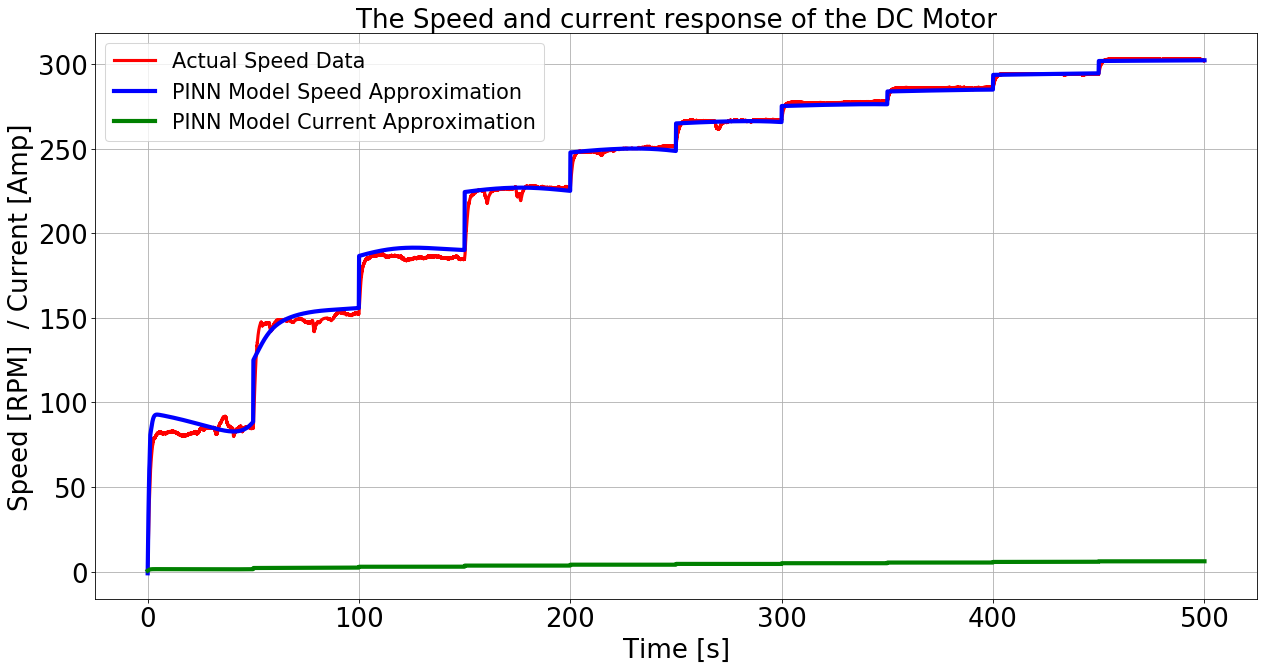

In [46]:
# Prediction with the new (test) data
psi_sh_hat_new= model2(tf.stack([t_new[:,0], v_new[:,0]], axis=1)) 
i_hat_new= model3(tf.stack([t_new[:,0], v_new[:,0]], axis=1)) 

from matplotlib.pyplot import figure
fig=plt.figure(figsize=(20,10),dpi=75)
plt.rcParams.update ({"font.size":25})
plt.plot(t_new, psi_new, color='r',linewidth=3,label="Actual Speed Data")
plt.plot(t_new, psi_sh_hat_new, color='b',linewidth=4,label="PINN Model Speed Approximation")

plt.plot(t_new, i_hat_new, color='g',linewidth=4,label="PINN Model Current Approximation")
plt.ylabel('Speed [RPM]  / Current [Amp]',fontsize=25)
plt.xlabel('Time [s]',fontsize=25)
plt.title('The Speed and current response of the DC Motor',fontsize=25)
plt.legend(loc=2, prop={'size': 20})
plt.grid(True)
plt.show()
fig.savefig("PINN model.png")

<h5> Model Save <h5>

In [ ]:
# Open a folder to save the entire model as a Saved Model
!mkdir -p saved_model

In [24]:
# Save the weights
#model1.save_weights ("saved_model/DC Motor_PINN_model1_weights_inverse_approach")
#model2.save_weights ("saved_model/DC Motor_PINN_model2_weights_inverse_approach")

# Restore the weights
model1.load_weights ("saved_model/DC Motor_PINN_model1_weights_inverse_approach")
model2.load_weights ("saved_model/DC Motor_PINN_model2_weights_inverse_approach")


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for saved_model/DC Motor_PINN_model1_weights_inverse_approach